In [1]:
from IPython.display import display
from PIL import Image

import numpy as np
import torch

from deep_cloost.losses import MSELoss
from deep_cloost.model import Encoder, SegmentedEncoder, MNISTRefiner

In [2]:
def display_image(arr):
    """Helper to render a normalized MNIST image."""
    img = (np.clip(arr*0.3081 + 0.1307, 0, 1) * 255).astype('uint8')
    display(Image.fromarray(img[0]))

In [48]:
# Create the model and load it from a file.
#
# This model has 10 stages, where each stage
# chooses from 64 options.
encoder = Encoder(shape=(1, 28, 28),
                  options=64,
                  refiner=MNISTRefiner(64, 10),
                  loss_fn=MSELoss(),
                  num_stages=10)
encoder.load_state_dict(torch.load('mnist_model.pt', map_location='cpu'))

<All keys matched successfully>

In [61]:
# Latent codes for this model are sequences of 10
# numbers between 0 and 64.
#
# Let's make an arbitrarily chosen latent code.
latents = torch.tensor([0, 10, 15, 20, 25, 30, 35, 40, 45, 50], dtype=torch.long)

In [62]:
# The decode() method on our model allows us to
# produce an image for a latent code.
image = encoder.decode(latents[None])[0]
display_image(image.detach().numpy())

In [63]:
# We can also try decoding the image stage by stage
# to see how each stage modifies the output.
images = torch.cat([encoder.decode(latents[None], num_stages=i+1) for i in range(10)])
display_image(np.concatenate(images.detach().numpy(), axis=-1))

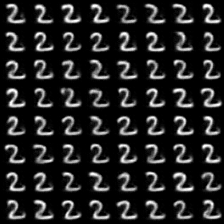

In [73]:
# The model works by proposing 64 different changes
# at each stage. Let's take a look at the options it
# proposed in the third stage.
stage = 3
partial_image = encoder.decode(latents[None], num_stages=stage-1)
proposals = encoder.apply_stage(stage-1, partial_image)[0]

# Create an 8x8 grid for the 64 proposals.
grid = proposals.view(8, 8, 1, 28, 28).detach().numpy()
image = np.concatenate(np.concatenate(grid, axis=-2), axis=-1)
display_image(image)